In [7]:
import json
import os
import sys

import torch
import torch.nn as nn
from tqdm import tqdm
from transformers import (
    AutoModel,
    AutoModelForCausalLM,
    AutoTokenizer,
    CLIPVisionModelWithProjection,
    ViTForImageClassification,
)

notebook_dir = os.path.dirname(os.path.abspath("__file__"))
project_root = os.path.abspath(os.path.join(notebook_dir, ".."))

if project_root not in sys.path:
    sys.path.append(project_root)

from VQ_SEEDLM import models
from datasets_weight_vector import get_datasets

In [8]:
model_path_list = [
    # "/home/jgryu/Weight_compression/VQ_SEEDLM/checkpoint/vqvae/Meta-Llama-3-8B/mlp_attn_16_row_dataset.pt/size16_enmse_neNone_de16_K8_P32_encdim512_batch_size2048_total_iter2000000_lr0.0001_seed100/best_mse_model_MSE_0.00335_total_iter_2000000.pth.tar",
    # "/home/jgryu/Weight_compression/VQ_SEEDLM/checkpoint/vqvae/Meta-Llama-3-8B/mlp_attn_16_row_dataset.pt/size16_nmse_neNone_de16_K8_P10_encdim512_batch_size2048_total_iter2000000_lr0.0001_seed100/best_mse_model_MSE_0.00472_total_iter_1550000.pth.tar",
    # "/home/jgryu/Weight_compression/VQ_SEEDLM/checkpoint/vqvae/Meta-Llama-3-8B/mlp_attn_16_row_dataset.pt/size16_enmse_neNone_de16_K8_P16_encdim512_batch_size2048_total_iter2000000_lr0.0001_seed100/best_mse_model_MSE_0.02292_total_iter_150000.pth.tar",
    "/home/jgryu/Weight_compression/VQ_SEEDLM/checkpoint/vqvae/Meta-Llama-3-8B/mlp_attn_16_row_dataset.pt/size16_ne16_denc512_P32_K8_de16_batch_size2048_total_iter2000000_lr0.0001_seed100/best_mse_model_MSE_0.0001_total_iter_300000.pth.tar",
    "/home/jgryu/Weight_compression/VQ_SEEDLM/checkpoint/vqvae/Meta-Llama-3-8B/mlp_attn_16_row_dataset.pt/size16_neNone_de16_K8_P4_encdim512_batch_size2048_total_iter2000000_lr0.0001_seed100/best_mse_model_MSE_0.11166_total_iter_850000.pth.tar",
    # "/home/jgryu/Weight_compression/VQ_SEEDLM/checkpoint/vqvae/Meta-Llama-3-8B/mlp_attn_16_row_dataset.pt/size16_enmse_neNone_de16_K8_P4_encdim512_batch_size2048_total_iter2000000_lr0.0001_seed100/best_mse_model_MSE_0.60428_total_iter_1200000.pth.tar",
    # "/home/jgryu/Weight_compression/VQ_SEEDLM/checkpoint/vqvae/Meta-Llama-3-8B/mlp_attn_16_row_dataset.pt/size16_enmse_neNone_de16_K8_P8_encdim512_batch_size2048_total_iter2000000_lr0.0001_seed100/best_mse_model_MSE_0.3045_total_iter_1850000.pth.tar",
    "/home/jgryu/Weight_compression/VQ_SEEDLM/checkpoint/vqvae/Meta-Llama-3-8B/mlp_attn_16_row_dataset.pt/size16_nmse_neNone_de16_K8_P12_encdim512_batch_size2048_total_iter2000000_lr0.0001_seed100/best_mse_model_MSE_0.00263_total_iter_1850000.pth.tar",
    "/home/jgryu/Weight_compression/VQ_SEEDLM/checkpoint/vqvae/Meta-Llama-3-8B/mlp_attn_16_row_dataset.pt/size16_nmse_neNone_de16_K8_P8_encdim512_batch_size2048_total_iter2000000_lr0.0001_seed100/best_mse_model_MSE_0.01813_total_iter_1500000.pth.tar",
    "/home/jgryu/Weight_compression/VQ_SEEDLM/checkpoint/vqvae/Meta-Llama-3-8B/mlp_attn_16_row_dataset.pt/size16_neNone_de16_K8_P6_encdim512_batch_size2048_total_iter2000000_lr0.0001_seed100/best_mse_model_MSE_0.03877_total_iter_800000.pth.tar",
    # "/home/jgryu/Weight_compression/VQ_SEEDLM/checkpoint/vqvae/Meta-Llama-3-8B/mlp_attn_16_row_dataset.pt/size16_enmse_neNone_de16_K8_P12_encdim512_batch_size2048_total_iter2000000_lr0.0001_seed100/best_mse_model_MSE_0.10131_total_iter_1900000.pth.tar",
    "/home/jgryu/Weight_compression/VQ_SEEDLM/checkpoint/vqvae/Meta-Llama-3-8B/mlp_attn_16_row_dataset.pt/size16_ne16_denc512_P16_K8_de16_batch_size2048_total_iter2000000_lr0.0001_seed100/best_mse_model_MSE_0.00197_total_iter_350000.pth.tar",
]
config_list = [
    # {"input_size": 16, "dim_encoder": 512, "P": 32, "K": 8, "n_resblock": 4, "dim_embeddings": 16},
    # {"input_size": 16, "dim_encoder": 512, "P": 10, "K": 8, "n_resblock": 4, "dim_embeddings": 16},
    # {"input_size": 16, "dim_encoder": 512, "P": 16, "K": 8, "n_resblock": 4, "dim_embeddings": 16},
    {"input_size": 16, "dim_encoder": 512, "P": 32, "K": 8, "n_resblock": 4, "dim_embeddings": 16},
    {"input_size": 16, "dim_encoder": 512, "P": 4, "K": 8, "n_resblock": 4, "dim_embeddings": 16},
    # {"input_size": 16, "dim_encoder": 512, "P": 4, "K": 8, "n_resblock": 4, "dim_embeddings": 16},
    # {"input_size": 16, "dim_encoder": 512, "P": 8, "K": 8, "n_resblock": 4, "dim_embeddings": 16},
    {"input_size": 16, "dim_encoder": 512, "P": 12, "K": 8, "n_resblock": 4, "dim_embeddings": 16},
    {"input_size": 16, "dim_encoder": 512, "P": 8, "K": 8, "n_resblock": 4, "dim_embeddings": 16},
    {"input_size": 16, "dim_encoder": 512, "P": 6, "K": 8, "n_resblock": 4, "dim_embeddings": 16},
    # {"input_size": 16, "dim_encoder": 512, "P": 12, "K": 8, "n_resblock": 4, "dim_embeddings": 16},
    {"input_size": 16, "dim_encoder": 512, "P": 16, "K": 8, "n_resblock": 4, "dim_embeddings": 16},
]

# config_list = [
#     # {"input_size": 16, "dim_encoder": 512, "P": 16, "ne": 256, "n_resblock": 4, "dim_embeddings": 16},
#     # {"input_size": 16, "dim_encoder": 512, "P": 32, "ne": 256, "n_resblock": 4, "dim_embeddings": 16},
#     # {"input_size": 16, "dim_encoder": 512, "P": 4, "ne": 256, "n_resblock": 4, "dim_embeddings": 16},
#     # {"input_size": 16, "dim_encoder": 512, "P": 6, "ne": 256, "n_resblock": 4, "dim_embeddings": 16},
# ]

with open(
    "/home/jgryu/Weight_compression/Wparam_dataset/dataset_block/meta-llama/Meta-Llama-3-8B/mlp_attn_16_row_dataset_stats.json",
    "r",
    encoding="utf-8",
) as file:
    dataset_stats = json.load(file)  # JSON 파일을 Python 객체로 변환

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

train_dataset, test_dataset, train_std, test_std = get_datasets("../Wparam_dataset/dataset_block/meta-llama/Meta-Llama-3-8B/mlp_attn_16_row_dataset.pt")

labels = [
        '6',
        '6.25',
        '12.5',
        '20.5',
]
results = {}


for model_path, config, l in zip(model_path_list, config_list, labels):
    model = models.VQVAE(
        input_size=config["input_size"],
        dim_encoder=config["dim_encoder"],
        P=config["P"],
        dim_embeddings=config["dim_embeddings"],
        n_embeddings=2 ** config["K"],
        n_resblock=config["n_resblock"],
        beta=0.25,
        scale=torch.Tensor(dataset_stats["train"]["std_channel"]).to(device),
        shift=torch.Tensor(dataset_stats["train"]["mean_channel"]).to(device),
    )
    ckpt = torch.load(model_path)
    model.load_state_dict(ckpt["state_dict"])
    model.to(device)
    
    mean_MSE = 0
    mse_func = torch.nn.MSELoss()

    device = next(model.parameters()).device

    out_list = []
    for idx, weight in enumerate(test_dataset) :
            weight = weight.to(device)
            x = weight.unsqueeze(0).to(device) # [1, 512, 512] 같음
            out = model(x.to(device))
            out_list.append(out)
            
            x_hat = out["x_hat"].clone().detach()
            mse = mse_func(x, x_hat).item()
            mean_MSE += mse
    
    mean_MSE /= len(test_dataset)
    results[l] = out_list

/home/jgryu/Weight_compression/notebooks/../VQ_SEEDLM/datasets_weight_vector.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(dataset_folder_path)
/tmp

6


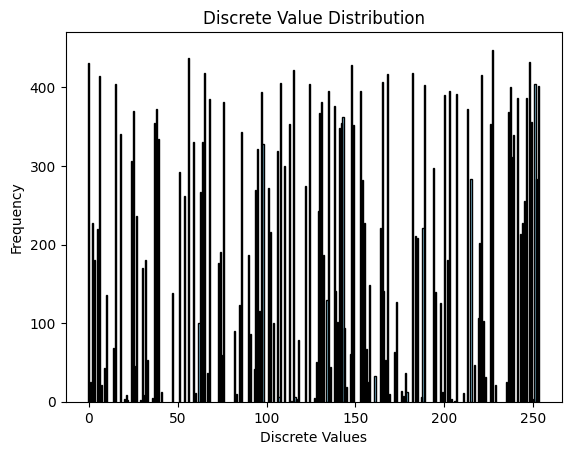

tensor(253, device='cuda:1')
tensor(0, device='cuda:1')
빈도수가 0이 아닌 값의 개수: 155
6.25


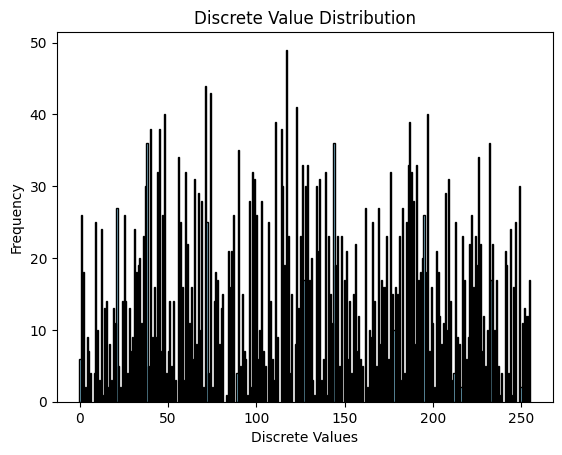

tensor(255, device='cuda:1')
tensor(0, device='cuda:1')
빈도수가 0이 아닌 값의 개수: 245
12.5


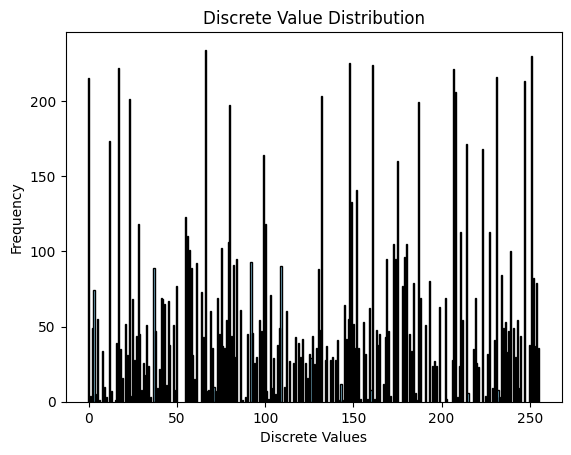

tensor(255, device='cuda:1')
tensor(0, device='cuda:1')
빈도수가 0이 아닌 값의 개수: 207
20.5


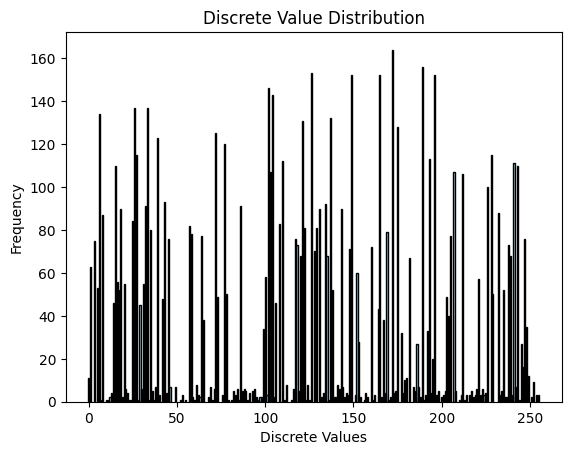

tensor(255, device='cuda:1')
tensor(0, device='cuda:1')
빈도수가 0이 아닌 값의 개수: 218


In [9]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

for l in labels:
    print(l)
    out_list = results[l]
    ids = []
    for i in out_list:
        ids.append(i['min_encoding_indices'])
    ids = torch.cat(ids, dim=0)

    counter = Counter(ids.view(-1).cpu().detach().numpy())  # Counter 객체를 사용하여 빈도 계산
    x_values = list(counter.keys())  # 데이터 값 (x축)
    y_values = list(counter.values())  # 빈도수 (y축)

    # 막대 그래프 그리기
    plt.bar(x_values, y_values, width=0.6, color='skyblue', edgecolor='black')

    # 그래프 꾸미기
    plt.title("Discrete Value Distribution")
    plt.xlabel("Discrete Values")
    plt.ylabel("Frequency")
    # plt.xticks(x_values)  # x축 눈금을 이산 값에 맞춤

    # 그래프 표시
    plt.show()

    # print(ids.mean())
    print(ids.max())
    print(ids.min())
    
    non_zero_count = sum(1 for count in counter.values() if count > 0)

    print("빈도수가 0이 아닌 값의 개수:", non_zero_count)
